In [1]:
from dtelib import DTEStreamer, get_stream_overview
from datetime import datetime
import xarray as xa
import rioxarray # noqa
from pyproj import CRS
from rasterio.transform import from_origin
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
token = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJ6Z2VPSi1PVkIxRXdkNk01blNEamZ0Vzd1WGpKa3hxMTdkV2FQbzd6NDIwIn0.eyJleHAiOjE3MjgwNTI4MjQsImlhdCI6MTcyODA1MjUyNCwiYXV0aF90aW1lIjoxNzI4MDUyNTI0LCJqdGkiOiIwMGM3NWY2Yy1jMWRkLTRkYTYtODQ4Yy1kZjgyMWQ5ZGEwNWEiLCJpc3MiOiJodHRwczovL2F1dGguZGVzdGluZS5ldS9yZWFsbXMvZGVzcCIsInN1YiI6Ijc0Y2RlZTRhLTJkZjYtNDk1Yi04ZWNhLThhZmMwZDA5OWJiMSIsInR5cCI6IkJlYXJlciIsImF6cCI6InN0cmVhbWluZy1mZSIsInNlc3Npb25fc3RhdGUiOiI5MTYxMjNiNS0zMWMzLTQ5NmEtOTNmMy05YjM0NDliMDJkMDUiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsiRFBBRF9EaXJlY3RfQWNjZXNzIl19LCJzY29wZSI6Im9wZW5pZCIsInNpZCI6IjkxNjEyM2I1LTMxYzMtNDk2YS05M2YzLTliMzQ0OWIwMmQwNSIsInByZWZlcnJlZF91c2VybmFtZSI6InNlYmFzdGllbi50ZXRhdWQiLCJhY2Nlc3NfZ3JvdXAiOlsiRFBBRF9EaXJlY3RfQWNjZXNzIl19.nszRI1uizo5lmrOCzbRLP78d4hYwsl0xgnNOnmeFWjW5gx6PCilYEuTszyldHCbkZgblHpuJXaeJyVHth4RbgY9cgNvlo2IYaxDVoyB8A1j7_FD1pDxDXgy0VbvTdHXJGxiFd55FnBOVcXLE_gfedb_6pzo28TZTv1k8NBfXCXvc9kHr4MPgrGWLos3-d6OIrVoHKVyni-BZ84rfBKsi-vve_gM3CLZlQY1qZ-yv_V7nlBTBHubS5klxfiZtl7WT9P4wXXyqJpklR1WZvxC5t-yXsql2wexxiq0Ka5N3WnZ6uc335OQdUOdDDRye44ZolYYjFlzYk9UeP5X7n0jM8w"

In [3]:
FORMAT = '%Y-%m-%dT%H:%M'
category_name = 'Era5'
short_name = '2t'
start_date = datetime.strptime('2023-12-31T12:00', FORMAT)
end_date = datetime.strptime('2023-12-31T12:00', FORMAT)

In [157]:
streamer = DTEStreamer(category_name=category_name,
                       short_name=short_name,
                       start_date=start_date,
                       end_date=end_date,
                       token=token)

time_series = list()
time_stamps = list()

for image, time_stamp in streamer.images():
    # if time_stamp.hour != 12:
    #     continue
    time_stamps.append(time_stamp)
    time_series.append(image)
    print(time_stamp)

2023-12-31 12:00:00


In [159]:
import numpy as np
import xarray as xr
# 1. Create the coordinate arrays
latitudes = np.linspace(-90, 90, 721)  # 721 latitude points from 90 to -90
longitudes = np.linspace(0, 359.75, 1440)
ds = xr.Dataset(
    data_vars={"t2m": (["latitude", "longitude"], time_series[0])},  # Define the data variable
    coords={"latitude": latitudes, "longitude": longitudes, "time": time_stamps[0]},  # Assign the coordinates
    attrs={"description": "2-meter temperature from ERA5"}
)
ds.coords['longitude'] = ((ds.coords['longitude'] + 180) % 360) - 180
ds = ds.sortby('longitude')
var = ds['t2m'] - 273.15
var = var.rename({'latitude': 'y', 'longitude': 'x'})
var.rio.write_crs("EPSG:4326", inplace=True)
# Only for not global datasets - If data contains NaN, replace it with -9999 to make them transparent afterwards (as soon as you then map this value to black in the colormap text file)
var_filled = var.fillna(-9999)
var.rio.to_raster('tif_filename.tif')

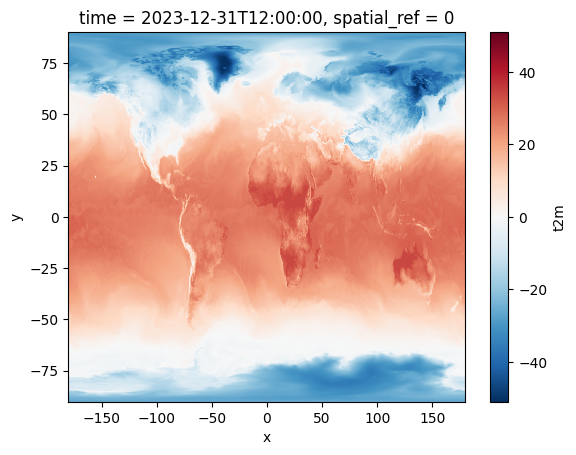

In [160]:
var.plot()

In [161]:
!gdal_translate -of VRT tif_filename.tif vrt_filename.vrt
!gdaldem color-relief  vrt_filename.vrt colormap.txt  output_vrt_filename.vrt
!gdal_translate -of COG output_vrt_filename.vrt output_cog_filename.tif
!rio cogeo create  output_cog_filename.tif era5_output_cog_optimised_filename.tif  --blocksize 512 --overview-resampling average --overview-level 8 --web-optimized

Input file size is 1440, 721
Input file size is 1440, 721
0...10...20...30...40...50...60...70...80...90...100 - done.
Defining overview's `blocksize` to match the high resolution `blocksize`: 512
Reading input: /home/ubuntu/project/DestinE_eXchange_SR/output_cog_filename.tif
  [####################################]  100%
Adding overviews...
Updating dataset tags...
Writing output to: era5_output_cog_optimised_filename.tif


In [15]:
## Climate DT

In [23]:
token = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJ6Z2VPSi1PVkIxRXdkNk01blNEamZ0Vzd1WGpKa3hxMTdkV2FQbzd6NDIwIn0.eyJleHAiOjE3MjgwMzUxODYsImlhdCI6MTcyODAzNDg4NiwiYXV0aF90aW1lIjoxNzI4MDM0ODg2LCJqdGkiOiI5Njc4YjFkMi01MzI3LTQ3YmMtOTUxNS02YWM1MTNjMTJmYzEiLCJpc3MiOiJodHRwczovL2F1dGguZGVzdGluZS5ldS9yZWFsbXMvZGVzcCIsInN1YiI6Ijc0Y2RlZTRhLTJkZjYtNDk1Yi04ZWNhLThhZmMwZDA5OWJiMSIsInR5cCI6IkJlYXJlciIsImF6cCI6InN0cmVhbWluZy1mZSIsInNlc3Npb25fc3RhdGUiOiJjMDRmNTkyZC0yM2ZlLTQ0MjUtYjQ0Yy1hMWZjY2QwZDRjMDYiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsiRFBBRF9EaXJlY3RfQWNjZXNzIl19LCJzY29wZSI6Im9wZW5pZCIsInNpZCI6ImMwNGY1OTJkLTIzZmUtNDQyNS1iNDRjLWExZmNjZDBkNGMwNiIsInByZWZlcnJlZF91c2VybmFtZSI6InNlYmFzdGllbi50ZXRhdWQiLCJhY2Nlc3NfZ3JvdXAiOlsiRFBBRF9EaXJlY3RfQWNjZXNzIl19.n8rm7snmm6RvLFNbjx5i-mp_1gGYcb3Z8QE1j-CAbYdBV_iGC4i5e86NdKzmrkfy-0Z_Oy9EtJ0OyNTsFG7YtG1NOECCQmYznVLYJlrx5btbDAjOSxQzPDjLdLf1qPyvwEtFjxodw60I6krRQykGhlrewUuTW8_0D4AgORBEPBl8VxkXSr8zL0xg4fh3pn-8HROTTTzv5Ym8bSmJRwyKCBpandPjHV9ni04fyQmBHSt04QgfDI5TqX2JoxknFgohYHd_7V2H6u_QPENl_3HR67DHjb8kUmNMPACmnKbvK3hJaZww1TQ0saqSVHC327O0Sc_J2RZznURfl4XzF_nXBg"

In [164]:
FORMAT = '%Y-%m-%dT%H:%M'
category_name = 'Climate DT'
short_name = '2t'
start_date = datetime.strptime('2024-08-15T00:00', FORMAT)
end_date = datetime.strptime('2024-08-15T00:00', FORMAT)
streamer = DTEStreamer(category_name=category_name,
                       short_name=short_name,
                       start_date=start_date,
                       end_date=end_date,
                       token=token)

time_series = list()
time_stamps = list()

for image, time_stamp in streamer.images():
    # if time_stamp.hour != 12:
    #     continue
    time_stamps.append(time_stamp)
    time_series.append(image)
    print(time_stamp)

2024-08-15 00:00:00


In [209]:
time_series[0].shape

(4096, 8193)

In [217]:
latitudes = np.linspace(-90, 90, 4096)
longitudes = np.linspace(-180, 180, 8193)
# 3. Create an xarray Dataset
ds = xr.Dataset(
    data_vars={"t2m": (["latitude", "longitude"], time_series[0][::-1, ::])},  # Define the data variable
    coords={"latitude": latitudes, "longitude": longitudes, "time": time_stamps[0]},  # Assign the coordinates
    attrs={"description": "2-meter temperature"}
)
var = ds['t2m'] - 273.15
var = var.rename({'latitude': 'y', 'longitude': 'x'})
var.rio.write_crs("EPSG:4326", inplace=True)
# If data contains NaN, replace it with -9999 to make them transparent afterwards
var_filled = var.fillna(-9999)
var_filled.rio.to_raster('tif_filename.tif')

In [212]:
!gdal_translate -of VRT tif_filename.tif vrt_filename.vrt
!gdaldem color-relief  vrt_filename.vrt colormap.txt  output_vrt_filename.vrt
!gdal_translate -of COG output_vrt_filename.vrt output_cog_filename.tif
!rio cogeo create  output_cog_filename.tif dte_output_cog_optimised_filename.tif  --blocksize 512 --overview-resampling average --overview-level 8 --web-optimized

Input file size is 8193, 4096
Input file size is 8193, 4096
0...10...20...30...40...50...60...70...80...90...100 - done.
Defining overview's `blocksize` to match the high resolution `blocksize`: 512
Reading input: /home/ubuntu/project/DestinE_eXchange_SR/output_cog_filename.tif
  [####################################]  100%          
Adding overviews...
Updating dataset tags...
Writing output to: dte_output_cog_optimised_filename.tif


In [4]:
var = ds.sel(**{"latitude": slice(47, 58.22), "longitude": slice(5, 16.25)})
var = var - 273.15
var = var.rename({'latitude': 'y', 'longitude': 'x'})
var.rio.write_crs("EPSG:4326", inplace=True)
var_filled = var.fillna(-9999)
var_filled.rio.to_raster('germany_tif_filename.tif')

NameError: name 'ds' is not defined

In [224]:
!gdal_translate -of VRT germany_tif_filename.tif vrt_filename.vrt
!gdaldem color-relief  vrt_filename.vrt colormap.txt  output_vrt_filename.vrt
!gdal_translate -of COG output_vrt_filename.vrt germany_cog_filename.tif
!rio cogeo create  germany_cog_filename.tif germany_output_cog_optimised_filename.tif  --blocksize 512 --overview-resampling average --overview-level 8 --web-optimized

Input file size is 256, 256
Input file size is 256, 256
0...10...20...30...40...50...60...70...80...90...100 - done.
Defining overview's `blocksize` to match the high resolution `blocksize`: 512
Reading input: /home/ubuntu/project/DestinE_eXchange_SR/germany_cog_filename.tif
  [####################################]  100%
Adding overviews...
Updating dataset tags...
Writing output to: germany_output_cog_optimised_filename.tif
